# Inspect Rich Documents with Gemini Multimodality and Multimodal RAG Challenge Lab

__Note__: if you encounter an authentication error when running the cells in the notebook, go to __Vertex AI__ > __Dashboard__, and click on __Enable All Recommended APIs__. Then, re-run the failed cell, and continue the lab.  

## Setup and requirements

### Install Vertex AI SDK for Python and other dependencies

Run the following four cells below before you get to Task 1. Be sure to add your current project ID to the cell titled __Define Google Cloud project information__. 

In [1]:
# "RUN THIS CELL AS IS"

# Install required python packages and other dependencies
!pip3 install --upgrade --user google-cloud-aiplatform

!pip3 install --upgrade --user google-cloud-aiplatform pymupdf

### Restart current runtime

You must restart the runtime in order to use the newly installed packages in this Jupyter runtime. You can do this by running the cell below, which will restart the current kernel.


In [2]:
# "RUN THIS CELL AS IS"

import IPython

# Restart the kernet after libraries are loaded.

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Define Google Cloud project information

In [1]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

import sys

# Define project information and update the location if it differs from the one specified in the lab instructions.
PROJECT_ID = "qwiklabs-gcp-00-0c81695f67f8"  # @param {type:"string"}
LOCATION = "us-east4"  # @param {type:"string"}

# Try to get the PROJECT_ID automatically.
if "google.colab" not in sys.modules:
    import subprocess

    PROJECT_ID = subprocess.check_output(
        ["gcloud", "config", "get-value", "project"], text=True
    ).strip()

print(f"Your project ID is: {PROJECT_ID}")


Your project ID is: qwiklabs-gcp-00-0c81695f67f8


In [2]:
# Please like share & subscribe to Techcps
# YouTube https://www.youtube.com/@techcps

print("Please like share & subscribe to Techcps https://www.youtube.com/@techcps")

Please like share & subscribe to Techcps https://www.youtube.com/@techcps


### Initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [3]:
# "RUN THIS CELL AS IS"

# Initialize Vertex AI.
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)


## Task 1. Generating Multimodal Insights with the Gemini Pro Vision model

Gemini 1.0 Pro Vision (gemini-1.0-pro-vision) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.

To complete Task 1, follow the instructions at the top of each notebook cell:
* Run the cells with the comment "RUN THIS CELL AS IS".
* Complete and run the cells with the comment "COMPLETE THE MISSING PART AND RUN THIS CELL".

__Note__: Ensure you can see the weather related data in the response that is printed.


### Setup and requirements for Task 1

#### Import libraries

In [4]:
# "RUN THIS CELL AS IS"

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

#### Load Gemini 1.0 Pro Vision model

In [5]:
# "RUN THIS CELL AS IS"

multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

#### Define helper functions

In [6]:
# "RUN THIS CELL AS IS"

import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

### Task 1.1. Image understanding across multiple images

In [7]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 

image_ask_first_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_1.png"
image_dont_do_this_1_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_1.png"
image_ask_first_1 = load_image_from_url(image_ask_first_1_url)
image_dont_do_this_1 = load_image_from_url(image_dont_do_this_1_url)

instructions = "Instructions: Consider the following image that contains text:"
prompt1 = "What is the title of this image"
prompt2 = """
Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:
"""

#### Create an input for the multimodal model

In [8]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [
    instructions,
    image_ask_first_1,
    prompt1,
    image_dont_do_this_1,
    prompt2,
]


#### Generate responses from the multimodal model

In [9]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from the multimodal model. Capture the output of the model in the "responses" variable by using your "contents" list.


responses = multimodal_model.generate_content(contents, stream=True)

#### Display the prompt and responses


-------Prompt-------
Instructions: Consider the following image that contains text:


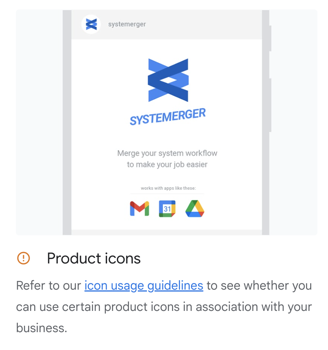

What is the title of this image


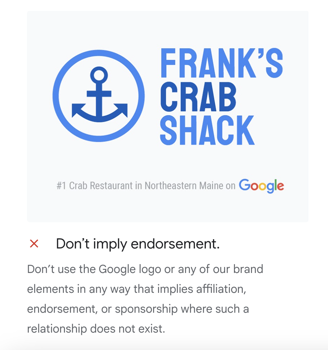


Answer the question through these steps:
Step 1: Identify the title of each image by using the filename of each image.
Step 2: Describe the image.
Step 3: For each image, describe the actions that a user is expected to take.
Step 4: Extract the text from each image as a full sentence.
Step 5: Describe the sentiment for each image with an explanation.

Answer and describe the steps taken:


-------Response-------
 **Image 1**
**Title:** systemerger
**Description:** The image is a screenshot of a web page that is promoting a product called "systemerger". The image features the systemerger logo and the text "systemerger" in the center of the page. The text below the logo says "Merge your system workflow to make your job easier". The page also features logos for Gmail, Google Calendar, and Google Drive.
**Actions:** The user is expected to read the text on the page and click on the links to learn more about the product.
**Text:** The text on the page says "systemerger. Merge your system w

In [10]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.


print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

### To verify your work for Task 1.1, click __Check my progress__ in the lab instructions.

### Task 1.2. Similarity/Differences between images

#### Explore the variables of the task

In [11]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 


image_ask_first_3_url = "https://storage.googleapis.com/spls/gsp520/Google_Branding/Ask_first_3.png"
image_dont_do_this_3_url =  "https://storage.googleapis.com/spls/gsp520/Google_Branding/Dont_do_this_3.png"
image_ask_first_3 = load_image_from_url(image_ask_first_3_url)
image_dont_do_this_3 = load_image_from_url(image_dont_do_this_3_url)

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?
"""



#### Create an input for the multimodal model

In [12]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt1, image_ask_first_3, prompt2, image_dont_do_this_3, prompt3]

#### Set configuration parameters

In [13]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to set configuration parameters that will influence how the multimodal model generates text. These settings control aspects like the creativity and focus of the responses. Here's how:
# Temperature: Controls randomness. Lower values mean more predictable results, higher values mean more surprising and creative outpu
# Top p / Top k: Affects how the model chooses words. Explore different values to see how they change the results.
# Other parameters: Check the model's documentation for additional options you might want to adjust.

# Store your configuration parameters in a generation_config variable. This improves reusability, allowing you to easily apply the same settings across tasks and make adjustments as needed.

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)


#### Generate responses from the multimodal model


In [14]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and the confiuguration settings.


responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)


#### Display the prompt and responses

-------Prompt-------

Consider the following two images:
Image 1:



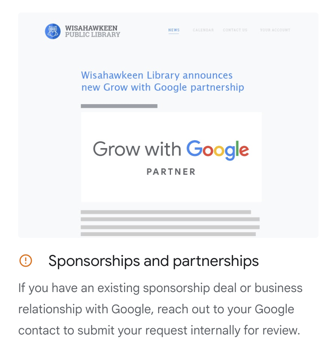


Image 2:



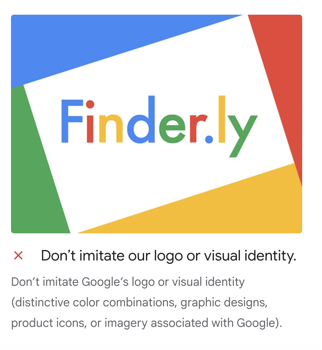


1. What is shown in Image 1 and Image 2?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the text ?


-------Response-------
 1. Image 1 is a screenshot of a web page that shows the logo of the Wishawken Public Library and the words "Grow with Google Partner". 
Image 2 is a screenshot of a web page that shows the logo of the company "Finder.ly" and the words "Don't imitate our logo or visual identity".


2. Both images are related to Google.


3. The text in Image 1 is "Sponsorships and partnerships. If you have an existing sponsorship deal or business relationship with Google, reach out to your Google contact to submit your request internally for review." 
The text in Image 2 is "Don't imitate our logo or visual identity (distinctive color combinations, graphic designs, product icons, or imagery associated with Google)."

In [15]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

### To verify your work for Task 1.2, click __Check my progress__ in the lab instructions.

### Task 1.3. Generate a video description

#### Explore the variables of the task


In [16]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
What is the product shown in this video?
What specific product features are highlighted in the video?
Where was this video filmed? Which cities around the world could potentially serve as the background in the video?
What is the sentiment of the video?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [17]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [18]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. Capture the output of the model in the "responses" variable by using your "contents" list.


responses = multimodal_model.generate_content(contents, stream=True)

#### Display the prompt and responses

**Note:** If you encounter any authentication error below cell run, go to the **Navigation menu**, click **Vertex AI > Dashboard**, then click **"Enable all Recommended APIs"** Now, go back to cell 16, and run cells 16, 17 and below cell.

In [19]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

-------Prompt-------

What is the product shown in this video?
What specific product features are highlighted in the video?
Where was this video filmed? Which cities around the world could potentially serve as the background in the video?
What is the sentiment of the video?




-------Response-------
 The product shown in this video is the Google Pixel 8 Pro.

The specific product features highlighted in the video are:

* The phone's AI capabilities, which are showcased through the features "Real Tone", "Photo Unblur", and "Magic Eraser".
* The phone's camera, which is highlighted through the ability to take photos and videos in low-light conditions.
* The phone's design, which is highlighted through the phone's sleek and modern look.

The video was filmed in London, England. Other cities around the world that could potentially serve as the background in the video include New York City, Paris, and Tokyo.

The sentiment of the video is positive and upbeat. The video highlights the phone's features in a fun and engaging way, and it is clear that the phone is designed to make people's lives easier and more enjoyable.

Proceed to Task 1.4 below (no progress check for Task 1.3 in lab instructions). 

### Task 1.4. Extract tags of objects throughout the video

#### Explore the variables of the task

In [20]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 

prompt = """
Answer the following questions using the video only:

Which particular sport is highlighted in the video?
What values or beliefs does the advertisement communicate about the brand?
What emotions or feelings does the advertisement evoke in the audience?
Which tags associated with objects featured throughout the video could be extracted?
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [21]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [22]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents, stream=True)

#### Display the prompt and responses

In [23]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

-------Prompt-------

Answer the following questions using the video only:

Which particular sport is highlighted in the video?
What values or beliefs does the advertisement communicate about the brand?
What emotions or feelings does the advertisement evoke in the audience?
Which tags associated with objects featured throughout the video could be extracted?




-------Response-------
 - The particular sport highlighted in the video is basketball.
- The advertisement communicates the following values or beliefs about the brand:
  - The Pixel 8 Pro is a powerful and versatile smartphone that can be used to capture and share life's moments, no matter where you are.
  - The Pixel 8 Pro is a great phone for staying connected with friends and family, and for capturing and sharing your memories.
  - The Pixel 8 Pro is a phone that can help you be more productive and creative.
- The advertisement evokes the following emotions or feelings in the audience:
  - Excitement
  - Happiness
  - Joy
  - Inspiration
- The following tags associated with objects featured throughout the video could be extracted:
  - #GooglePixel8Pro
  - #Basketball
  - #Friends
  - #Family
  - #Memories
  - #Creativity
  - #Productivity

Proceed to Task 1.5 below (no progress check for Task 1.4 in lab instructions). 

### Task 1.5. Ask more questions about a video

**Note:** Although this video contains audio, Gemini does not currently support audio input and will only answer based on the video.

#### Explore the variables of the task

In [24]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
Answer the following questions using the video only:

How does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?
What visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?
How does the advertisement depict the role of friendship and social connections in enhancing experiences and creating memories?
Are there any specific features or functionalities of the phone highlighted in the advertisement, besides its AI capabilities?

Provide the answer JSON.
"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)


#### Create an input for the multimodal model

In [25]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [26]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents, stream=True)

#### Display the prompt and responses

In [27]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

-------Prompt-------

Answer the following questions using the video only:

How does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?
What visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?
How does the advertisement depict the role of friendship and social connections in enhancing experiences and creating memories?
Are there any specific features or functionalities of the phone highlighted in the advertisement, besides its AI capabilities?

Provide the answer JSON.




-------Response-------
 ```json
{
  "questions": [
    {
      "question": "How does the advertisement portray the use of technology, specifically AI, in capturing and preserving memories?",
      "answer": "The advertisement portrays AI as a tool that can help capture and preserve memories in a more immersive and personal way. For example, the advertisement shows how AI can be used to create a 3D model of a person, which can then be used to create a personalized video. The advertisement also shows how AI can be used to identify and enhance specific moments in a video, such as a person's smile or a special event."
    },
    {
      "question": "What visual cues or storytelling elements contribute to the nostalgic atmosphere of the advertisement?",
      "answer": "The advertisement uses a variety of visual cues and storytelling elements to contribute to the nostalgic atmosphere of the advertisement. For example, the advertisement uses a warm and inviting color palette, as well as sof

Proceed to Task 1.6 below (no progress check for Task 1.5 in lab instructions). 

### Task 1.6. Retrieve extra information beyond the video

#### Explore the variables of the task

In [28]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


prompt = """
Answer the following questions using the video only:

How does the advertisement appeal to its target audience through its messaging and imagery?
What overall message or takeaway does the advertisement convey about the brand and its products?
Are there any symbolic elements or motifs used throughout the advertisement to reinforce its central themes?
What is the best hashtag for this video based on the description ?

"""
video = Part.from_uri(
    uri="gs://spls/gsp520/google-pixel-8-pro.mp4",
    mime_type="video/mp4",
)

#### Create an input for the multimodal model

In [29]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Now, you're going to create an input for your multimodal model. Create your contents list using the variables above. Ensure the structure matches the format expected by the multimodal model.

contents = [prompt, video]

#### Generate responses from the multimodal model

In [30]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the next part of this task, you're going to generate responses from a multimodal model. capture the output of the model in the "responses" variable by using your "contents" list and video input.


responses = multimodal_model.generate_content(contents, stream=True)

#### Display the prompt and responses

In [31]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# In the last part of this task, you're going to print your contents and responses with the prompt and responses title provided. Use descriptive titles to help organize the output (e.g., "Prompts", "Model Responses") and then display the prompt and responses by using the print() function. 

# Hint: "\n" inserts a newline character for clearer separation between the sections.

print("-------Prompt-------")
print_multimodal_prompt(contents)

print("\n-------Response-------")
for response in responses:
    print(response.text, end="")

-------Prompt-------

Answer the following questions using the video only:

How does the advertisement appeal to its target audience through its messaging and imagery?
What overall message or takeaway does the advertisement convey about the brand and its products?
Are there any symbolic elements or motifs used throughout the advertisement to reinforce its central themes?
What is the best hashtag for this video based on the description ?





-------Response-------
 The advertisement appeals to its target audience by featuring a diverse range of people using the phone in various everyday situations. The ad highlights the phone's features, such as the ability to take great photos and videos, make video calls, and use AI to enhance photos. The ad also emphasizes the phone's sleek design and durability.

The overall message of the advertisement is that the Google Pixel 8 Pro is a great choice for anyone looking for a top-of-the-line smartphone. The ad highlights the phone's many features and benefits, and it is clear that the phone is designed to appeal to a wide range of consumers.

There are several symbolic elements or motifs used throughout the advertisement to reinforce its central themes. For example, the ad features several shots of people taking photos and videos, which highlights the phone's camera capabilities. The ad also features several shots of people using the phone's AI features, such as the ability to transla

### To verify your work for Task 1.6, click __Check my progress__ in the lab instructions.

## Task 2. Retrieving and integrating knowledge with multimodal retrieval augmented generation (RAG)

To complete Task 2, follow the instructions at the top of each notebook cell:
* Run the cells with the comment "RUN THIS CELL AS IS".
* Complete and run the cells with the comment "COMPLETE THE MISSING PART AND RUN THIS CELL".

For additional information about the available data and helper functions for Task 2, review the section named __Available data and helper functions for Task 2__ in the lab instructions.

### Setup and requirements for Task 2

#### Import libraries

In [32]:
# "RUN THIS CELL AS IS"

# Import necessary packages and libraries.

from IPython.display import Markdown, display
from vertexai.generative_models import (
    Content,
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Image,
    Part,
)


#### Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model

In [33]:
# "RUN THIS CELL AS IS"

# Load the Gemini 1.0 Pro and Gemini 1.0 Pro Vision model.

text_model = GenerativeModel("gemini-1.0-pro")
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

#### Download custom Python modules and utilities 

The cell below will download some helper functions needed for this notebook, to improve readability. You can also view the code (`intro_multimodal_rag_utils.py`) directly on [Github](https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

In [34]:
# "RUN THIS CELL AS IS"

# Import necessary packages and libraries.
import os
import urllib.request
import sys

if not os.path.exists("utils"):
    os.makedirs("utils")


# Download the helper scripts from utils folder.
url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/use-cases/retrieval-augmented-generation/utils/"
files = ["intro_multimodal_rag_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")


#### Get documents and images from Cloud Storage

In [35]:
# "RUN THIS CELL AS IS"

# Download documents and images used in this notebook.

!gsutil -m rsync -r gs://spls/gsp520 .
print("Download completed")

Building synchronization state...
Starting synchronization...
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_2.png...
Copying gs://spls/gsp520/Google_Branding/Ask_first_2.png...                     
Copying gs://spls/gsp520/Google_Branding/Ask_first_1.png...                     
Copying gs://spls/gsp520/Google_Branding/Go_for_it_1.png...                     
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_4.png...                  
Copying gs://spls/gsp520/Google_Branding/.DS_Store...
Copying gs://spls/gsp520/Google_Branding/Ask_first_3.png...                     
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_1.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_5.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_3.png...                  
Copying gs://spls/gsp520/Google_Branding/Dont_do_this_6.png...                  
Copying gs://spls/gsp520/Google_Branding/Go_for_it_2.png...                     
Copying gs:

### Task 2.1. Build metadata of documents containing text and images

__Note__: These steps may take a few minutes to complete.

#### Import helper functions to build metadata

In [35]:
# "RUN THIS CELL AS IS"

# Import helper functions from utils.
from utils.intro_multimodal_rag_utils import get_document_metadata

#### Explore the variables of the task

In [36]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 


# Specify the "PDF folder path" with single PDF and "PDF folder" with multiple PDF.

pdf_folder_path = "Google_Branding/"  # if running in Vertex AI Workbench.

# Specify the image description prompt. Change it
image_description_prompt = """Explain what is going on in the image.
If it's a table, extract all elements of the table.
If it's a graph, explain the findings in the graph.
Do not include any numbers that are not mentioned in the image.
"""


#### Extract and store metadata of text and images from a document

In [37]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call the "get_document_metadata" function from the utils file to extract text and image metadata from the PDF document. Store the results in two different DataFrames: "text_metadata_df" and "image_metadata_df".  
# text_metadata_df: This will contain extracted text snippets, their corresponding page numbers, and potentially other relevant information.
# image_metadata_df: This will contain descriptions of the images found in the PDF (if any), along with their location within the document.

text_metadata_df, image_metadata_df = get_document_metadata(
    multimodal_model, # we are passing gemini 1.0 pro vision model
    pdf_folder_path,
    image_save_dir="images",
    image_description_prompt=image_description_prompt,
    embedding_size=1408,
)

print("\n\n --- Completed processing. ---")



 Processing the file: --------------------------------- Google_Branding/Google_terms_of_service_en_us.pdf 


Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10
Processing page: 11
Processing page: 12
Processing page: 13
Processing page: 14
Processing page: 15
Processing page: 16


 --- Completed processing. ---


#### Inspect the processed text metadata

In [38]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Explore the text_metadata_df dataframe by displaying the first few rows of the dataframe.

text_metadata_df.head()

,file_name,page_num,text,text_embedding_page,chunk_number,chunk_text,text_embedding_chunk
0,Google_terms_of_service_en_us.pdf,1,"GOOGLE TERMS OF SERVICE\nEffective January 5, ...","[0.018420301377773285, -0.035995256155729294, ...",1,"GOOGLE TERMS OF SERVICE\nEffective January 5, ...","[0.018351567909121513, -0.023393990471959114, ..."
1,Google_terms_of_service_en_us.pdf,1,"GOOGLE TERMS OF SERVICE\nEffective January 5, ...","[0.018420301377773285, -0.035995256155729294, ...",2,"ongs to you, Google, or others\nIn case of pro...","[0.012958074919879436, -0.02373543567955494, -..."
2,Google_terms_of_service_en_us.pdf,2,"Google services are provided by, and youre con...","[0.022008631378412247, -0.03146402910351753, 0...",1,"Google services are provided by, and youre con...","[0.01956416666507721, -0.030242910608649254, 0..."
3,Google_terms_of_service_en_us.pdf,2,"Google services are provided by, and youre con...","[0.022008631378412247, -0.03146402910351753, 0...",2,\nto use our services if you agree to follow t...,"[0.023477822542190552, -0.03806876018643379, 0..."
4,Google_terms_of_service_en_us.pdf,3,apps and sites (like Search and Maps)\nplatfor...,"[0.008536546491086483, 0.007520652376115322, -...",1,apps and sites (like Search and Maps)\nplatfor...,"[-0.014875887893140316, 0.0004349025839474052,..."


#### Import the helper functions to implement RAG

In [39]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Import helper functions from utils.

from utils.intro_multimodal_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    get_similar_image_from_query,
    print_text_to_image_citation,
    get_gemini_response,
    display_images,
)

Proceed to Task 2.2 below (no progress check for Task 2.1 in lab instructions). 

### Task 2.2. Create a user query

#### Explore the variables of the task

In [40]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. 
# First, review and describe the content/purpose of each variable below. 

query = """Questions:
 - What are the key expectations that users can have from Google regarding the provision and development of its services?
- What specific rules and guidelines are established for users when using Google services?
- How does Google handle intellectual property rights related to the content found within its services, including content owned by users, Google, and third parties? 
- What legal rights and remedies are available to users in case of problems or disagreements with Google?
- How do the service-specific additional terms interact with these general Terms of Service, and which terms take precedence in case of any conflicts?
 """

Proceed to Task 2.3 below (no progress check for Task 2.2 in lab instructions).

### Task 2.3. Get all relevant text chunks

#### Retrieve relevant chunks of text based on the query

In [41]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call the "get_similar_text_from_query" function from the utils file to retrieve relevant chunks of text based on the query. Store the results in a dictionart called "matching_results_chunks_data".  
# matching_results_chunks_data: This dictionary will contain file_name, page_num, cosine_score, chunk_number and chunk_socre. The dictionary represents a search result for a query related to the text_metadata_df.

matching_results_chunks_data = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=10,
    chunk_text=True,
)


#### Display the first item of the text chunk dictionary

In [42]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Explore the first item in your matching_results_chunks_data dictionary by displaying the first item.

print_text_to_text_citation(
    matching_results_chunks_data,
    print_top=False,
    chunk_text=True,
)

Citation 1: Matched text: 

score:  0.88
file_name:  Google_terms_of_service_en_us.pdf
page_number:  1
chunk_number:  1
chunk_text:  GOOGLE TERMS OF SERVICE
Effective January 5, 2022
Archived versions
Whats covered in these terms
We know its tempting to skip these Terms of Service, but
its important to establish what you can expect from us as
you use Google services, and what we expect from you.
These Terms of Service reflect the way Googles business works, the laws that apply to our company, and
certain things weve always believed to be true. As a result, these Terms of Service help define Googles
relationship with you as you interact with our services. For example, these terms include the following topic
headings:
What you can expect from us, which describes how we provide and develop our services
What we expect from you, which establishes certain rules for using our services
Content in Google services, which describes the intellectual property rights to the content you find in our
s

Proceed to Task 2.4 below (no progress check for Task 2.3 in lab instructions).

### Task 2.4. Create context_text

#### Create a list to store the combined chunks of text

In [43]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"


# Create an empty list named "context_text". This list will be used to store the combined chunks of text.
context_text = list()


#### Iterate through each item in the text chunks dictionary

In [44]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Create a for loop to iterate through each item in the matching_results_chunks_data dictionary in order to combine all the selected relevant text chunks

for key, value in matching_results_chunks_data.items():
    context_text.append(value["chunk_text"]) 


#### Join all the text chunks and store in a list

In [45]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Take all of the individual text chunks stored in the context_text list and join them together into a single string named final_context_text. Use "\n" part inserts a newline character between each chunk, effectively creating separate lines or paragraphs.

final_context_text = "\n".join(context_text)

Proceed to Task 2.5 below (no progress check for Task 2.4 in lab instructions).

### Task 2.5. Pass context to Gemini

#### Explore the variables of the task


In [46]:
# "RUN THIS CELL AS IS"

# You're going to work with provided variables in this task. First, review and describe the content/purpose of each variable below. 

prompt = f""" Instructions: Compare the images and the text provided as Context: to answer multiple Question:
Make sure to think thoroughly before answering the question and put the necessary steps to arrive at the answer in bullet points for easy explainability.
If unsure, respond, "Not enough context to answer".

Context:
 - Text Context:
 {final_context_text}


{query}

Answer:
"""

#### Generate Gemini response with streaming output

In [48]:
# "COMPLETE THE MISSING PART AND RUN THIS CELL"

# Call "get_gemini_response" function from utils module in order to generate Gemini response with streaming output. This function uses a multimodal Gemini model, a text prompt, and configuration parameters and instructs the Gemini model to generate a response using the provided prompt. As Gemini model enables streaming, you will receive chunks of the response as they were produced. 
# Format the streamed output using Markdown syntax for easy readability and conversion to HTML.

Markdown(
    get_gemini_response(
        multimodal_model,
        model_input=[prompt],
        stream=True,
        generation_config=GenerationConfig(temperature=0.2, max_output_tokens=2048),
    )
)

1. **What are the key expectations that users can have from Google regarding the provision and development of its services?**
 - Google provides a broad range of useful services that are subject to these terms.
 - Google continuously improves its services to meet the needs of its users.
 - Google provides reasonable advance notice before making material changes that negatively impact the use of its services or if it stops offering a service.
 - Google provides users with an opportunity to export their content from their Google Account using Google Takeout, subject to applicable law and policies.


2. **What specific rules and guidelines are established for users when using Google services?**
 - Users must follow these terms and service-specific additional terms.
 - Users may not copy, modify, distribute, sell, or lease any part of Google's services or software.
 - Users must not use Google services for illegal or harmful purposes.
 - Users must not violate the intellectual property rights of others.


3. **How does Google handle intellectual property rights related to the content found within its services, including content owned by users, Google, and third parties?**
 - Google respects the intellectual property rights of others.
 - Google may remove content that violates the intellectual property rights of others.
 - Google may terminate the access of users who repeatedly infringe the intellectual property rights of others.


4. **What legal rights and remedies are available to users in case of problems or disagreements with Google?**
 - Users have the right to file a complaint with Google.
 - Users may have the right to seek legal action against Google.
 - Google is liable only for its breaches of these terms or applicable service-specific additional terms.
 - Google is not liable for indirect or consequential losses, punitive damages, or loss of profits.


5. **How do the service-specific additional terms interact with these general Terms of Service, and which terms take precedence in case of any conflicts?**
 - The service-specific additional terms govern for that service in case of any conflicts with these general Terms of Service.

### To verify your work for Task 2.5, click __Check my progress__ in the lab instructions.